# Backpropagation in Multilayer Neural Networks

While we will primarily be working with high-level, abstract toolkits like Keras in this course, understanding how backpropagation works is absolutely essential to using neural networks. 

In this exercise, we will build our own backpropagation algorithm - working through each step, to ensure that we can follow it.

Just like in Lab 1, we'll be working with the MNIST dataset. We will load it and plot an example:

In [474]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

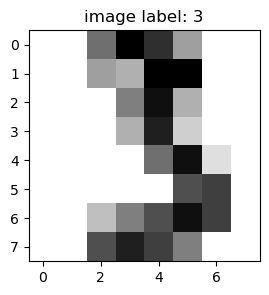

In [475]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

Of course, we need to split our data into training and testing sets before we use it, just the same as in Lab 1:

In [476]:
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# Numpy Implementation

## a) Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

- Implement the softmax function $\sigma(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$;
- Implement the negative log likelihood function $NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}$;
- Train a logistic regression model on the MNIST dataset;
- Evaluate the model on the training and testing sets.

Before we get there, let's write a function that one-hot encodes the class labels:

In [477]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [478]:
one_hot(n_classes=10, y=3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [479]:
one_hot(n_classes=10, y=[0, 4, 9, 1])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### The softmax function

Now we will implement the softmax function. Recall that the softmax function is defined as follows:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

This is implemented for you using numpy - we want to be able to apply the softmax function to a batch of samples at once, so we will use numpy's vectorized operations to do so.

Our method also handles _stability issues_ that can occur when the values in `X` are very large. We will subtract the maximum value from each row of `X` to avoid overflow in the exponentiation. This isn't part of the softmax function itself, but it's a useful trick to know about.

In [480]:
def softmax(X):
    X_max = np.max(X, axis=-1, keepdims=True)
    exp = np.exp(X - X_max) # Subtract the max to avoid overflow in the exponentiation
    return exp / np.sum(exp, axis=-1, keepdims=True)


Let's make sure that this works one vector at a time (and check that the components sum to one):

In [481]:
print(softmax([10, 2, -3]))

[9.99662391e-01 3.35349373e-04 2.25956630e-06]


When we are using our model to make predictions, we will want to be able to make predictions for multiple samples at once.
Let's make sure that our implementation of softmax works for a batch of samples:

In [482]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


Probabilities should sum to 1:

In [483]:
print(np.sum(softmax([10, 2, -3])))

1.0


In [484]:
print("softmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

softmax of 2 vectors:
[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


The sum of probabilities for each input vector of logits should some to 1:

In [485]:
print(np.sum(softmax(X), axis=1))

[1. 1.]


Now we will implement a function that, given the true one-hot encoded class `Y_true` and some predicted probabilities `Y_pred`, returns the negative log likelihood.

Recall that the negative log likelihood is defined as follows:

$$
NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}
$$

For example, if we have $y_{true} = [1, 0, 0]$ and $y_{pred} = [0.99, 0.01, 0]$, then the negative log likelihood is $- \log(0.99) \approx 0.01$.

In [486]:
def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)

    # Ensure Y_pred doesn't have zero probabilities to avoid log(0)
    Y_pred = np.clip(Y_pred, 1e-15, 1 - 1e-15)

    # Calculate negative log likelihood
    loss = -np.sum(Y_true * np.log(Y_pred))
    return loss

# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

0.01005033585350145


We should see a very high value for this negative log likelihood, since the model is very confident that the third class is the correct one, but the true class is the first one:

In [487]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

4.605170185988091


Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be past as 2D arrays:

In [488]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.010050335853503449


Now that we have our softmax and negative log likelihood functions, we can implement a logistic regression model. 
In this section, we have built the model for you, but you will need to complete a few key parts.

**YOUR TURN:**

1. Implement the `forward` method of the `LogisticRegression` class. This method should take in a batch of samples `X` and return the predicted probabilities for each class. You should use the softmax function that we implemented earlier.
2. Implement the `loss` method of the `LogisticRegression` class. This method take in the samples `X` and the true values `y` and return the average negative log likelihood of the predictions.

In [489]:
import numpy as np

def one_hot(num_classes, labels):
    """
    Convert class labels (integers) to one-hot encoded format.
    """
    one_hot_matrix = np.zeros((len(labels), num_classes))
    one_hot_matrix[np.arange(len(labels)), labels] = 1
    return one_hot_matrix

class LogisticRegression:

    def __init__(self, input_size, output_size):
        # Initialize weights and biases
        self.W = np.random.uniform(low=-0.1, high=0.1, size=(input_size, output_size))
        self.b = np.random.uniform(low=-0.1, high=0.1, size=output_size)

        # Store dimensions
        self.input_size = input_size
        self.output_size = output_size

    def forward(self, X):
        # Linear transformation + softmax
        Z = np.dot(X, self.W) + self.b
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # stability trick
        softmax_output = exp_Z / np.sum(exp_Z, axis=1, keepdims=True)
        return softmax_output

    def predict(self, X):
        # Predict class with highest probability
        if len(X.shape) == 1:
            X = X.reshape(1, -1)
        return np.argmax(self.forward(X), axis=1)

    def loss(self, X, y):
        # Negative log-likelihood loss
        y_pred = self.forward(X)
        log_likelihood = -np.log(y_pred[range(len(y)), y.astype(int)])
        return np.mean(log_likelihood)

    def grad_loss(self, X, y_true, y_pred):
        # Gradient of the loss wrt weights and biases
        y_true_onehot = one_hot(self.output_size, y_true.astype(int))
        grad_W = np.dot(X.T, (y_pred - y_true_onehot)) / len(X)
        grad_b = np.sum(y_pred - y_true_onehot, axis=0) / len(X)
        return grad_W, grad_b

# Test the implementation
model = LogisticRegression(input_size=64, output_size=10)
try:
    assert(model.forward(np.zeros((1, 64))).shape == (1, 10))
    assert(model.loss(np.zeros((1, 64)), np.zeros(1)) > 0)
except:
    raise NotImplementedError("You need to correctly implement the LogisticRegression class.")


In [490]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
lr = LogisticRegression(n_features, n_classes)

We can evaluate the model on an example, visualizing the prediction probabilities:

In [491]:
import matplotlib.pyplot as plt

def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # Show the image
    ax0.imshow(X_test[sample_idx].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title(f"True image label: {y_test[sample_idx]}")

    # One-hot true label and predicted probabilities
    true_onehot = one_hot(len(classes), np.array([y_test[sample_idx]]))[0]
    pred_probs = model.forward(X_test[sample_idx:sample_idx+1])[0]

    ax1.bar(classes, true_onehot, label='True', alpha=0.6)
    ax1.bar(classes, pred_probs, label='Prediction', alpha=0.6, color="red")
    ax1.set_xticks(classes)
    ax1.set_xlabel('Digit class')
    ax1.set_ylabel('Probability')
    ax1.set_title(f"Predicted: {np.argmax(pred_probs)}")
    ax1.legend()

    plt.tight_layout()
    plt.show()

    

Now it's time to start training! We will train for a single epoch, and then evaluate the model on the training and testing sets. Read through the following and make sure that you understand what we are doing here.

In [492]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from sklearn.preprocessing import OneHotEncoder
from packaging import version
import sklearn

# 1. Load and preprocess data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(-1, 28 * 28).astype(np.float32) / 255.0
X_test = X_test.reshape(-1, 28 * 28).astype(np.float32) / 255.0

# 2. Helper: one-hot encoding
def one_hot(num_classes, y):
    y = y.reshape(-1, 1)
    if version.parse(sklearn.__version__) >= version.parse("1.2"):
        encoder = OneHotEncoder(categories='auto', sparse_output=False)
    else:
        encoder = OneHotEncoder(categories='auto', sparse=False)
    return encoder.fit_transform(np.eye(num_classes)[y.astype(int).ravel()])

# 3. Define Logistic Regression class
class LogisticRegression:
    def __init__(self, input_size, output_size):
        self.W = np.random.randn(input_size, output_size) * 0.01
        self.b = np.zeros((1, output_size))
        self.output_size = output_size

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # stability trick
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, x):
        return self.softmax(np.dot(x, self.W) + self.b)

    def loss(self, x, y_true):
        y_pred = self.forward(x)
        n = y_true.shape[0]
        return -np.sum(np.log(y_pred[np.arange(n), y_true])) / n

    def grad_loss(self, x, y_true_one_hot, y_pred):
        m = x.shape[0]
        dz = y_pred - y_true_one_hot
        dW = np.dot(x.T, dz) / m
        db = np.sum(dz, axis=0, keepdims=True) / m
        return dW, db

# 4. Initialize model
lr = LogisticRegression(input_size=784, output_size=10)
learning_rate = 0.01
epochs = 1  # Increase if needed

# 5. Train on a subset for demo
for epoch in range(epochs):
    for i in range(1000):  # training on first 1000 samples
        x = X_train[i:i+1]
        y = y_train[i:i+1]
        y_true_oh = one_hot(10, y)
        y_pred = lr.forward(x)
        grad_W, grad_b = lr.grad_loss(x, y_true_oh, y_pred)
        lr.W -= learning_rate * grad_W
        lr.b -= learning_rate * grad_b
        if i % 200 == 0:
            print(f"Step {i}, Loss: {lr.loss(x, y):.4f}")

# 6. Evaluate
y_pred_test = lr.forward(X_test)
predicted_classes = np.argmax(y_pred_test, axis=1)
accuracy = np.mean(predicted_classes == y_test)
print(f"\n✅ Test Accuracy (first 1000-trained model): {accuracy:.4f}")


Step 0, Loss: 2.2894
Step 200, Loss: 2.2816
Step 400, Loss: 2.3447
Step 600, Loss: 2.3061
Step 800, Loss: 2.2794

✅ Test Accuracy (first 1000-trained model): 0.0890


Evaluate the trained model on the first example:

Step 0, Loss: 2.4285
Step 200, Loss: 2.3543
Step 400, Loss: 2.2670
Step 600, Loss: 2.2893
Step 800, Loss: 2.3001

✅ Test Accuracy (first 1000-trained model): 0.0889


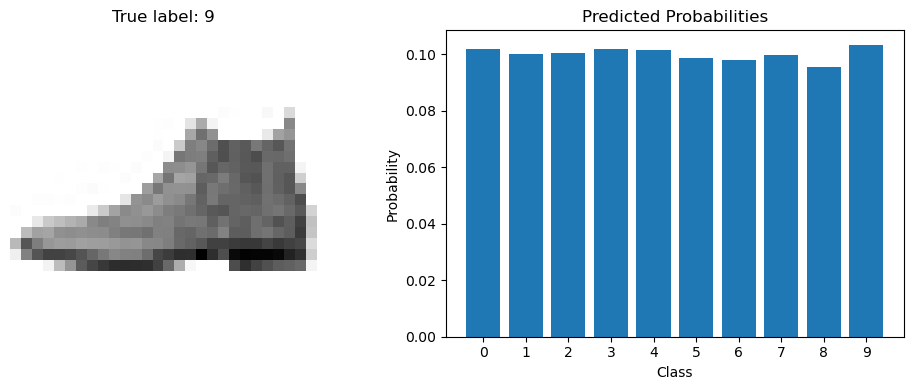

In [493]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from sklearn.preprocessing import OneHotEncoder
from packaging import version
import sklearn

# 1. Load and preprocess data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(-1, 28 * 28).astype(np.float32) / 255.0
X_test = X_test.reshape(-1, 28 * 28).astype(np.float32) / 255.0

# 2. Helper: one-hot encoding
def one_hot(num_classes, y):
    y = y.reshape(-1, 1)
    if version.parse(sklearn.__version__) >= version.parse("1.2"):
        encoder = OneHotEncoder(categories='auto', sparse_output=False)
    else:
        encoder = OneHotEncoder(categories='auto', sparse=False)
    return encoder.fit_transform(np.eye(num_classes)[y.astype(int).ravel()])

# 3. Define Logistic Regression class
class LogisticRegression:
    def __init__(self, input_size, output_size):
        self.W = np.random.randn(input_size, output_size) * 0.01
        self.b = np.zeros((1, output_size))
        self.output_size = output_size

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # stability trick
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, x):
        return self.softmax(np.dot(x, self.W) + self.b)

    def loss(self, x, y_true):
        y_pred = self.forward(x)
        n = y_true.shape[0]
        return -np.sum(np.log(y_pred[np.arange(n), y_true])) / n

    def grad_loss(self, x, y_true_one_hot, y_pred):
        m = x.shape[0]
        dz = y_pred - y_true_one_hot
        dW = np.dot(x.T, dz) / m
        db = np.sum(dz, axis=0, keepdims=True) / m
        return dW, db

# 4. Initialize model
lr = LogisticRegression(input_size=784, output_size=10)
learning_rate = 0.01
epochs = 1  # Increase if needed

# 5. Train on a subset for demo
for epoch in range(epochs):
    for i in range(1000):  # training on first 1000 samples
        x = X_train[i:i+1]
        y = y_train[i:i+1]
        y_true_oh = one_hot(10, y)
        y_pred = lr.forward(x)
        grad_W, grad_b = lr.grad_loss(x, y_true_oh, y_pred)
        lr.W -= learning_rate * grad_W
        lr.b -= learning_rate * grad_b
        if i % 200 == 0:
            print(f"Step {i}, Loss: {lr.loss(x, y):.4f}")

# 6. Evaluate model
y_pred_test = lr.forward(X_test)
predicted_classes = np.argmax(y_pred_test, axis=1)
accuracy = np.mean(predicted_classes == y_test)
print(f"\n✅ Test Accuracy (first 1000-trained model): {accuracy:.4f}")

# 7. Plot Prediction Function
def plot_prediction(model, sample_idx=0):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # Show the image
    ax0.imshow(X_test[sample_idx].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title(f"True label: {y_test[sample_idx]}")
    ax0.axis("off")

    # Predict probabilities
    probs = model.forward(X_test[sample_idx:sample_idx+1]).flatten()

    # Plot probabilities
    ax1.bar(range(10), probs)
    ax1.set_xticks(range(10))
    ax1.set_xlabel("Class")
    ax1.set_ylabel("Probability")
    ax1.set_title("Predicted Probabilities")

    plt.tight_layout()
    plt.show()

# 8. Visualize one prediction
plot_prediction(lr, sample_idx=0)


## b) Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

Now it's your turn to

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

Remember that you can use your `sigmoid` function inside your `dsigmoid` function.

Just like with our softmax function, we also want to make sure that we don't run into stability issues with our sigmoid function. We will use `np.clip` to ensure that the input to the sigmoid function is not too large or too small.

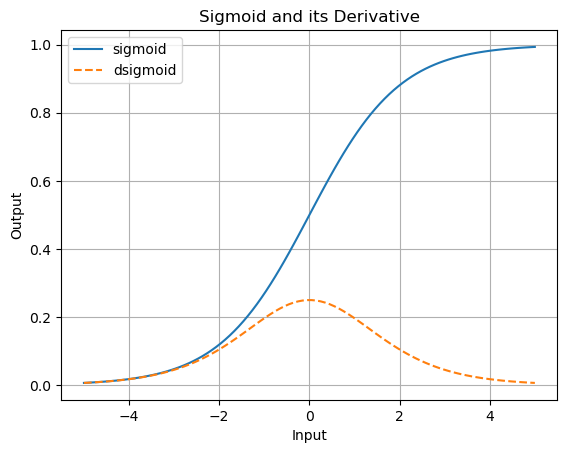

In [494]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(X):
    # Clip X to prevent overflow/underflow in exp()
    X = np.clip(X, -500, 500)
    return 1 / (1 + np.exp(-X))

def dsigmoid(X):
    s = sigmoid(X)
    return s * (1 - s)

# Generate input range
x = np.linspace(-5, 5, 100)

# Plot sigmoid and its derivative
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid', linestyle='--')
plt.title("Sigmoid and its Derivative")
plt.xlabel("Input")
plt.ylabel("Output")
plt.legend(loc='best')
plt.grid(True)
plt.show()


Now it's your turn to complete the neural network code, so that we can train it on the MNIST dataset.

Some parts have been completed for you already. Often, you'll be able to refer back to the code from the previous section to help you complete the code in this section.

In [495]:
import numpy as np

def sigmoid(X):
    X = np.clip(X, -500, 500)
    return 1 / (1 + np.exp(-X))

def dsigmoid(X):
    s = sigmoid(X)
    return s * (1 - s)

def one_hot(num_classes, labels):
    one_hot_matrix = np.zeros((len(labels), num_classes))
    one_hot_matrix[np.arange(len(labels)), labels] = 1
    return one_hot_matrix

class NeuralNet():
    """MLP with 1 hidden layer using sigmoid activations"""

    def __init__(self, input_size, hidden_size, output_size):
        self.W_h = np.random.uniform(size=(input_size, hidden_size), low=-0.1, high=0.1)
        self.b_h = np.random.uniform(size=hidden_size, low=-0.1, high=0.1)
        self.W_o = np.random.uniform(size=(hidden_size, output_size), low=-0.1, high=0.1)
        self.b_o = np.random.uniform(size=output_size, low=-0.1, high=0.1)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

    def forward_hidden(self, X):
        self.Z_h = np.dot(X, self.W_h) + self.b_h
        return sigmoid(self.Z_h)

    def forward_output(self, H):
        self.Z_o = np.dot(H, self.W_o) + self.b_o
        return sigmoid(self.Z_o)

    def forward(self, X):
        H = self.forward_hidden(X)
        Y = self.forward_output(H)
        return Y

    def loss(self, X, y):
        y = y.astype(int)
        y_onehot = one_hot(self.output_size, y)
        y_pred = self.forward(X)
        # Binary cross-entropy loss
        epsilon = 1e-12
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(np.sum(y_onehot * np.log(y_pred), axis=1))

    def grad_loss(self, X, y_true):
        y_true = one_hot(self.output_size, y_true)
        y_pred = self.forward(X)

        error_o = y_pred - y_true
        grad_W_o = np.dot(self.Z_h.T, error_o)
        grad_b_o = np.sum(error_o, axis=0)

        error_h = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h)
        grad_W_h = np.dot(X.T, error_h)
        grad_b_h = np.sum(error_h, axis=0)

        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        x = x[np.newaxis, :]  # Ensure 2D
        grads = self.grad_loss(x, y)

        self.W_h -= learning_rate * grads["W_h"]
        self.b_h -= learning_rate * grads["b_h"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X[np.newaxis, :]))
        return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        return np.mean(self.predict(X) == y)


Once the code is written, we can test our model on a single sample:

In [496]:
sample_idx = 0
sample_input = X_test[sample_idx]
true_label = y_test[sample_idx]

predicted_label = np.argmax(lr.forward(sample_input[np.newaxis, :]))
output_probs = lr.forward(sample_input[np.newaxis, :])[0]

print(f"True label: {true_label}")
print(f"Predicted label: {predicted_label}")
print("Output probabilities:")
print(np.round(output_probs, 3))

True label: 9
Predicted label: 9
Output probabilities:
[0.102 0.1   0.1   0.102 0.101 0.099 0.098 0.099 0.096 0.103]


In [497]:
# Initialize model
import numpy as np

# One-hot encoding helper
def one_hot(num_classes, labels):
    one_hot_matrix = np.zeros((len(labels), num_classes))
    one_hot_matrix[np.arange(len(labels)), labels] = 1
    return one_hot_matrix

# Logistic Regression Model
class LogisticRegression:
    def __init__(self, input_size, output_size):
        self.W = np.random.uniform(low=-0.1, high=0.1, size=(input_size, output_size))
        self.b = np.random.uniform(low=-0.1, high=0.1, size=output_size)
        self.input_size = input_size
        self.output_size = output_size

    def forward(self, X):
        Z = np.dot(X, self.W) + self.b
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # stability
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

    def predict(self, X):
        if len(X.shape) == 1:
            X = X.reshape(1, -1)
        return np.argmax(self.forward(X), axis=1)

    def loss(self, X, y):
        y_pred = self.forward(X)
        log_likelihood = -np.log(y_pred[np.arange(len(y)), y])
        return np.mean(log_likelihood)

    def grad_loss(self, X, y, y_pred):
        y_true_onehot = one_hot(self.output_size, y)
        grad_W = np.dot(X.T, (y_pred - y_true_onehot)) / len(X)
        grad_b = np.sum(y_pred - y_true_onehot, axis=0) / len(X)
        return grad_W, grad_b

    def accuracy(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

# ----------- TRAINING -----------


# Example initialization
model = LogisticRegression(input_size=X_train.shape[1], output_size=10)
learning_rate = 0.01

# Training loop
for i in range(len(X_train)):
    x = X_train[i:i+1]
    y = y_train[i:i+1]
    y_pred = model.forward(x)
    grad_W, grad_b = model.grad_loss(x, y, y_pred)
    model.W -= learning_rate * grad_W
    model.b -= learning_rate * grad_b

    if i % 100 == 0:
        loss_val = model.loss(X_train, y_train)
        print(f"Step {i}, Loss: {loss_val:.4f}")

# Evaluation
train_acc = model.accuracy(X_train, y_train)
test_acc = model.accuracy(X_test, y_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Step 0, Loss: 2.4652
Step 100, Loss: 1.5598
Step 200, Loss: 1.2844
Step 300, Loss: 1.2484
Step 400, Loss: 1.0425
Step 500, Loss: 0.9585
Step 600, Loss: 1.0364
Step 700, Loss: 0.8774
Step 800, Loss: 0.8882
Step 900, Loss: 0.8355
Step 1000, Loss: 0.7902
Step 1100, Loss: 0.7997
Step 1200, Loss: 0.7493
Step 1300, Loss: 0.7796
Step 1400, Loss: 0.7686
Step 1500, Loss: 0.8025
Step 1600, Loss: 0.8792
Step 1700, Loss: 0.8774
Step 1800, Loss: 0.7114
Step 1900, Loss: 0.8451
Step 2000, Loss: 0.6732
Step 2100, Loss: 0.6687
Step 2200, Loss: 0.6785
Step 2300, Loss: 0.6983
Step 2400, Loss: 0.7125
Step 2500, Loss: 0.6912
Step 2600, Loss: 0.6318
Step 2700, Loss: 0.6884
Step 2800, Loss: 0.7207
Step 2900, Loss: 0.6489
Step 3000, Loss: 0.7645
Step 3100, Loss: 0.6213
Step 3200, Loss: 0.6439
Step 3300, Loss: 0.8249
Step 3400, Loss: 0.6515
Step 3500, Loss: 0.6306
Step 3600, Loss: 0.8391
Step 3700, Loss: 0.6087
Step 3800, Loss: 0.6961
Step 3900, Loss: 0.6765
Step 4000, Loss: 0.6506
Step 4100, Loss: 0.7668
Step

In [498]:
import numpy as np

def one_hot(num_classes, labels):
    one_hot_matrix = np.zeros((len(labels), num_classes))
    one_hot_matrix[np.arange(len(labels)), labels] = 1
    return one_hot_matrix

class LogisticRegression:
    def __init__(self, input_size, output_size):
        self.W = np.random.uniform(low=-0.1, high=0.1, size=(input_size, output_size))
        self.b = np.random.uniform(low=-0.1, high=0.1, size=output_size)
        self.input_size = input_size
        self.output_size = output_size

    def forward(self, X):
        Z = np.dot(X, self.W) + self.b
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # numerical stability
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

    def predict(self, X):
        if len(X.shape) == 1:
            X = X.reshape(1, -1)
        return np.argmax(self.forward(X), axis=1)

    def loss(self, X, y):
        y_pred = self.forward(X)
        log_likelihood = -np.log(y_pred[range(len(y)), y.astype(int)])
        return np.mean(log_likelihood)

    def grad_loss(self, X, y_true, y_pred):
        y_true_onehot = one_hot(self.output_size, y_true.astype(int))
        grad_W = np.dot(X.T, (y_pred - y_true_onehot)) / len(X)
        grad_b = np.sum(y_pred - y_true_onehot, axis=0) / len(X)
        return grad_W, grad_b

    def accuracy(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

# Example training loop
lr = LogisticRegression(input_size=X_train.shape[1], output_size=10)
learning_rate = 0.01

for i in range(len(X_train)):
    x = X_train[i:i+1]
    y = y_train[i:i+1]
    y_pred = lr.forward(x)
    grad_W, grad_b = lr.grad_loss(x, y, y_pred)
    lr.W -= learning_rate * grad_W
    lr.b -= learning_rate * grad_b

    if i % 100 == 0:
        avg_nll = lr.loss(X_train[max(0, i-100):i+1], y_train[max(0, i-100):i+1])
        print(f"Step {i}, Avg NLL: {avg_nll:.4f}")

# Evaluate model accuracy
train_acc = lr.accuracy(X_train, y_train)
test_acc = lr.accuracy(X_test, y_test)
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Step 0, Avg NLL: 0.4750
Step 100, Avg NLL: 1.3845
Step 200, Avg NLL: 1.0220
Step 300, Avg NLL: 1.3070
Step 400, Avg NLL: 0.9669
Step 500, Avg NLL: 0.6854
Step 600, Avg NLL: 0.8342
Step 700, Avg NLL: 0.6163
Step 800, Avg NLL: 0.6205
Step 900, Avg NLL: 0.6237
Step 1000, Avg NLL: 0.6524
Step 1100, Avg NLL: 0.5550
Step 1200, Avg NLL: 0.6033
Step 1300, Avg NLL: 0.7031
Step 1400, Avg NLL: 0.6506
Step 1500, Avg NLL: 0.7732
Step 1600, Avg NLL: 0.5065
Step 1700, Avg NLL: 0.5975
Step 1800, Avg NLL: 0.5727
Step 1900, Avg NLL: 0.6349
Step 2000, Avg NLL: 0.4911
Step 2100, Avg NLL: 0.6095
Step 2200, Avg NLL: 0.5652
Step 2300, Avg NLL: 0.5344
Step 2400, Avg NLL: 0.7111
Step 2500, Avg NLL: 0.5365
Step 2600, Avg NLL: 0.5180
Step 2700, Avg NLL: 0.5189
Step 2800, Avg NLL: 0.6833
Step 2900, Avg NLL: 0.5028
Step 3000, Avg NLL: 0.7157
Step 3100, Avg NLL: 0.4954
Step 3200, Avg NLL: 0.3830
Step 3300, Avg NLL: 0.6202
Step 3400, Avg NLL: 0.5651
Step 3500, Avg NLL: 0.4241
Step 3600, Avg NLL: 0.8801
Step 3700, Av

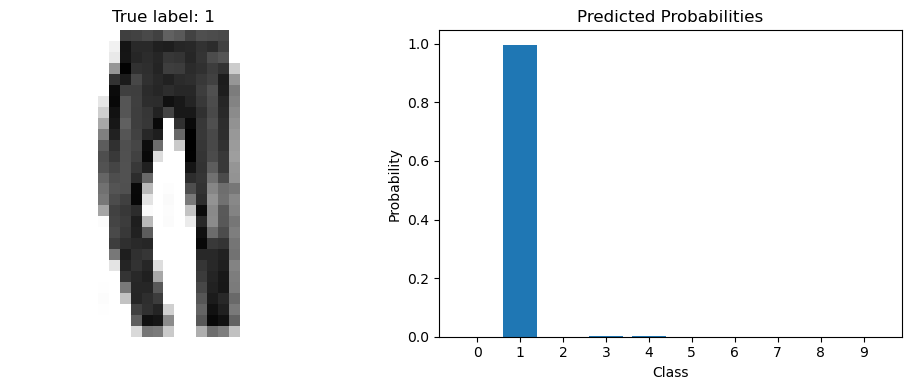

In [499]:
plot_prediction(model, sample_idx=5)

And now it's time to train!

In [500]:
def grad_loss(self, X, y_true):
    # Ensure y_true is an array of shape (1,) if it's a single label
    if np.isscalar(y_true):
        y_true = np.array([y_true])
    
    y_true = one_hot(self.output_size, y_true)
    y_pred = self.forward(X)

    error_o = y_pred - y_true
    grad_W_o = np.dot(self.Z_h.T, error_o)
    grad_b_o = np.sum(error_o, axis=0)

    error_h = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h)
    grad_W_h = np.dot(X.T, error_h)
    grad_b_h = np.sum(error_h, axis=0)

    return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7660 - loss: 0.6733 - val_accuracy: 0.8457 - val_loss: 0.4342
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8554 - loss: 0.4057 - val_accuracy: 0.8615 - val_loss: 0.3906
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8743 - loss: 0.3497 - val_accuracy: 0.8687 - val_loss: 0.3610
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8827 - loss: 0.3188 - val_accuracy: 0.8763 - val_loss: 0.3482
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8885 - loss: 0.3044 - val_accuracy: 0.8753 - val_loss: 0.3484
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8946 - loss: 0.2833 - val_accuracy: 0.8847 - val_loss: 0.3277
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8990 - loss: 0.2737 - val_accuracy: 0.8814 - val_loss: 0.3291
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9036 - loss: 0.2589 - 

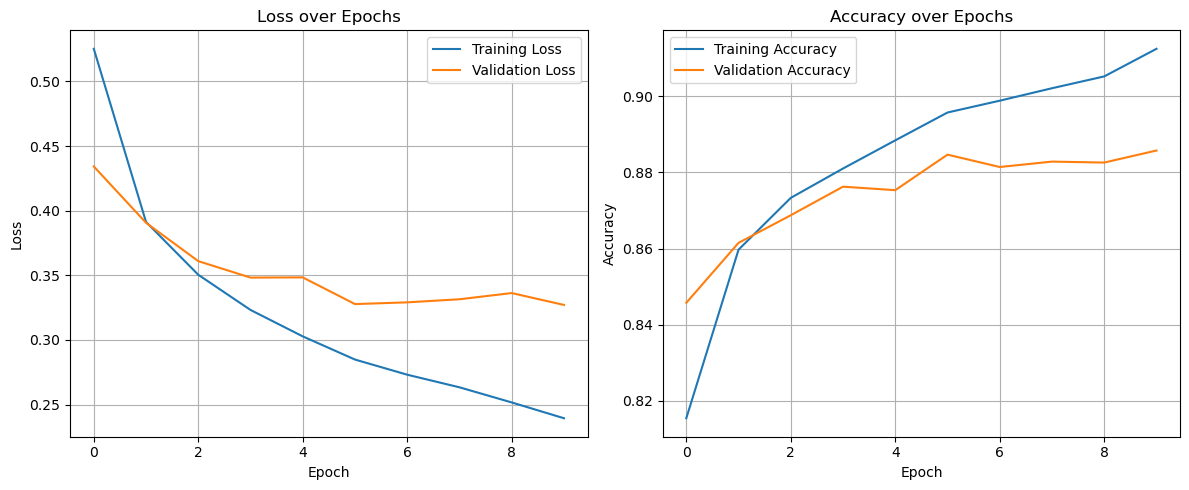

✅ Test Accuracy: 0.8767
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


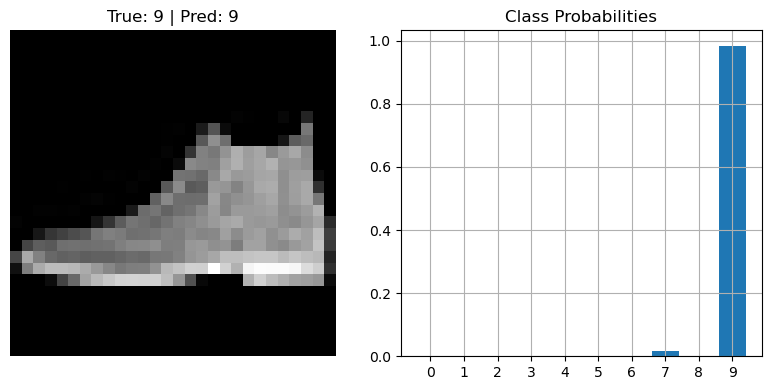

In [501]:

# 1. Import Libraries

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# 2. Load and Preprocess Data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize pixel values to range [0, 1]
X_train, X_test = X_train / 255.0, X_test / 255.0

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# 3. Build the Model (with Input layer to avoid warnings)
model = Sequential([
    Input(shape=(28, 28)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# 4. Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 5. Train the Model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

# 6. Plot Training and Validation Loss & Accuracy
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 7. Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {test_accuracy:.4f}")

# 8. Optional: Visualize Prediction for One Test Image
def plot_prediction(index=0):
    image = X_test[index].reshape(1, 28, 28)
    prediction = model.predict(image)[0]
    predicted_label = np.argmax(prediction)
    true_label = np.argmax(y_test[index])

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(X_test[index], cmap='gray')
    plt.title(f"True: {true_label} | Pred: {predicted_label}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.bar(range(10), prediction)
    plt.xticks(range(10))
    plt.title("Class Probabilities")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
plot_prediction(index=0)


In [502]:
# Step 8: Visualize a test image prediction
def plot_prediction_cnn(model, index=0):
    image = X_test[index].reshape(28, 28)
    true_label = np.argmax(y_test[index])
    prediction = model.predict(X_test[index:index+1].reshape(1, 28, 28, 1))[0]
    predicted_label = np.argmax(prediction)

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"True: {true_label} | Pred: {predicted_label}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.bar(range(10), prediction)
    plt.xticks(range(10))
    plt.title("Class Probabilities")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [503]:
import matplotlib.pyplot as plt
import numpy as np

# Class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def plot_prediction(model, X_test, y_test, sample_idx=0):


    # Ensure image has the right shape (expand dims if needed)
    if X_test.ndim == 3:
        X_sample = X_test[sample_idx][..., np.newaxis]  # Convert (28, 28) to (28, 28, 1)
        X_batch = np.expand_dims(X_sample, axis=0)      # Shape: (1, 28, 28, 1)
    else:
        X_batch = X_test[sample_idx:sample_idx+1]       # Already has channel dimension

    # Predict probabilities
    probs = model.predict(X_batch, verbose=0).flatten()
    pred_class = np.argmax(probs)
    true_class = np.argmax(y_test[sample_idx])

    # Plotting
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))

    # Image
    ax0.imshow(X_test[sample_idx], cmap='gray')
    ax0.set_title(f"True: {class_names[true_class]}\nPredicted: {class_names[pred_class]}")
    ax0.axis("off")

    # Bar chart of probabilities
    ax1.bar(range(10), probs, tick_label=class_names)
    ax1.set_title("Prediction Probabilities")
    ax1.set_xticklabels(class_names, rotation=45, ha="right")
    ax1.set_ylim([0, 1])

    plt.tight_layout()
    plt.show()


## c) Exercises

### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?

In [504]:
# Class labels for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Function to plot a test image and its prediction probabilities
def plot_prediction(model, X_test, y_test, sample_idx=0):
    """
    Visualizes the test image, true label, predicted label, and prediction probabilities.
    """
    # Get input sample and ensure correct shape
    sample_image = X_test[sample_idx]
    if sample_image.ndim == 3:
        sample_input = np.expand_dims(sample_image, axis=0)  # Shape: (1, 28, 28, 1)
    else:
        raise ValueError("Expected input image to have 3 dimensions (H, W, C)")

    # Predict probabilities
    probs = model.predict(sample_input, verbose=0).flatten()
    pred_class = np.argmax(probs)
    true_class = np.argmax(y_test[sample_idx])

    # Plotting
    fig, (ax_img, ax_bar) = plt.subplots(1, 2, figsize=(10, 4))

    # Image + label
    ax_img.imshow(sample_image.reshape(28, 28), cmap='gray')
    ax_img.set_title(f"True: {class_names[true_class]}\nPred: {class_names[pred_class]}")
    ax_img.axis("off")

    # Bar chart of probabilities
    ax_bar.bar(range(10), probs, tick_label=class_names)
    ax_bar.set_title("Prediction Probabilities")
    ax_bar.set_xticklabels(class_names, rotation=45, ha="right")
    ax_bar.set_ylim([0, 1])

    plt.tight_layout()
    plt.show()


### Hyper parameters settings

- Experiment with different hyperparameters:
  - learning rate,
  - size of hidden layer,
  - implement the support for a second hidden layer.
  - What is the best test accuracy you can get?

Epoch 1: Loss=2.3155, Train Acc=0.101, Test Acc=0.092
Epoch 2: Loss=2.3014, Train Acc=0.101, Test Acc=0.092
Epoch 3: Loss=2.2670, Train Acc=0.106, Test Acc=0.097
Epoch 4: Loss=2.1222, Train Acc=0.231, Test Acc=0.211
Epoch 5: Loss=1.7894, Train Acc=0.474, Test Acc=0.442
Epoch 6: Loss=1.4660, Train Acc=0.605, Test Acc=0.611
Epoch 7: Loss=1.1701, Train Acc=0.726, Test Acc=0.731
Epoch 8: Loss=0.9614, Train Acc=0.782, Test Acc=0.786
Epoch 9: Loss=0.8236, Train Acc=0.830, Test Acc=0.844
Epoch 10: Loss=0.7133, Train Acc=0.848, Test Acc=0.858
Epoch 11: Loss=0.6247, Train Acc=0.864, Test Acc=0.867
Epoch 12: Loss=0.5550, Train Acc=0.885, Test Acc=0.886
Epoch 13: Loss=0.4941, Train Acc=0.904, Test Acc=0.892
Epoch 14: Loss=0.4355, Train Acc=0.919, Test Acc=0.908
Epoch 15: Loss=0.3785, Train Acc=0.931, Test Acc=0.917

🎯 Best Test Accuracy: 0.917


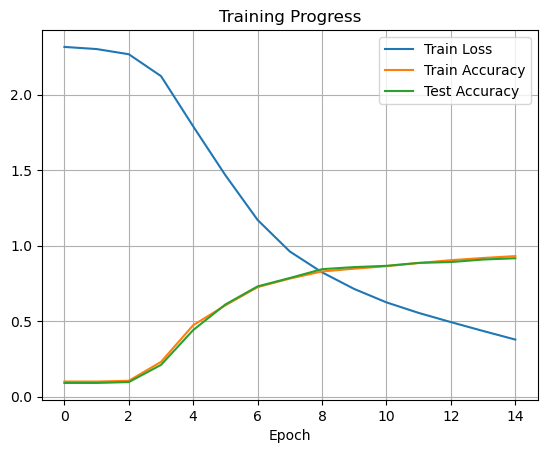

In [505]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --------------------- Helper Functions ---------------------
def sigmoid(X):
    X = np.clip(X, -500, 500)
    return 1 / (1 + np.exp(-X))

def dsigmoid(X):
    s = sigmoid(X)
    return s * (1 - s)

def one_hot(num_classes, labels):
    one_hot_matrix = np.zeros((len(labels), num_classes))
    one_hot_matrix[np.arange(len(labels)), labels] = 1
    return one_hot_matrix

# --------------------- Neural Network ---------------------
class NeuralNet:
    def __init__(self, input_size, hidden_size_1, output_size, hidden_size_2=None):
        self.use_second_hidden = hidden_size_2 is not None

        self.W1 = np.random.uniform(-0.1, 0.1, size=(input_size, hidden_size_1))
        self.b1 = np.random.uniform(-0.1, 0.1, size=hidden_size_1)

        if self.use_second_hidden:
            self.W2 = np.random.uniform(-0.1, 0.1, size=(hidden_size_1, hidden_size_2))
            self.b2 = np.random.uniform(-0.1, 0.1, size=hidden_size_2)
            self.W_out = np.random.uniform(-0.1, 0.1, size=(hidden_size_2, output_size))
        else:
            self.W_out = np.random.uniform(-0.1, 0.1, size=(hidden_size_1, output_size))

        self.b_out = np.random.uniform(-0.1, 0.1, size=output_size)

    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = sigmoid(self.Z1)

        if self.use_second_hidden:
            self.Z2 = np.dot(self.A1, self.W2) + self.b2
            self.A2 = sigmoid(self.Z2)
            self.Z_out = np.dot(self.A2, self.W_out) + self.b_out
        else:
            self.Z_out = np.dot(self.A1, self.W_out) + self.b_out

        return sigmoid(self.Z_out)

    def loss(self, X, y):
        y = y.astype(int)
        y_onehot = one_hot(self.W_out.shape[1], y)
        y_pred = self.forward(X)
        y_pred = np.clip(y_pred, 1e-12, 1 - 1e-12)
        return -np.mean(np.sum(y_onehot * np.log(y_pred), axis=1))

    def accuracy(self, X, y):
        return np.mean(self.predict(X) == y)

    def predict(self, X):
        if len(X.shape) == 1:
            X = X[np.newaxis, :]
        return np.argmax(self.forward(X), axis=1)

    def train(self, x, y, lr):
        if np.isscalar(y):
            y = np.array([y])
        x = x[np.newaxis, :]

        y_true = one_hot(self.W_out.shape[1], y)
        y_pred = self.forward(x)

        error_out = y_pred - y_true

        if self.use_second_hidden:
            dW_out = np.dot(self.A2.T, error_out)
            db_out = np.sum(error_out, axis=0)

            error_hidden2 = np.dot(error_out, self.W_out.T) * dsigmoid(self.Z2)
            dW2 = np.dot(self.A1.T, error_hidden2)
            db2 = np.sum(error_hidden2, axis=0)

            error_hidden1 = np.dot(error_hidden2, self.W2.T) * dsigmoid(self.Z1)
            dW1 = np.dot(x.T, error_hidden1)
            db1 = np.sum(error_hidden1, axis=0)

            self.W2 -= lr * dW2
            self.b2 -= lr * db2
        else:
            dW_out = np.dot(self.A1.T, error_out)
            db_out = np.sum(error_out, axis=0)

            error_hidden1 = np.dot(error_out, self.W_out.T) * dsigmoid(self.Z1)
            dW1 = np.dot(x.T, error_hidden1)
            db1 = np.sum(error_hidden1, axis=0)

        self.W1 -= lr * dW1
        self.b1 -= lr * db1
        self.W_out -= lr * dW_out
        self.b_out -= lr * db_out

# --------------------- Load Dataset ---------------------
digits = load_digits()
X, y = digits.data, digits.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n_features = X.shape[1]  # 64
n_classes = len(np.unique(y))  # 10

# --------------------- Hyperparameters ---------------------
learning_rate = 0.01
hidden_size_1 = 64
hidden_size_2 = 32  # Set to None for 1-layer network
epochs = 15

# --------------------- Train the Model ---------------------
model = NeuralNet(n_features, hidden_size_1, n_classes, hidden_size_2)

losses, accs_train, accs_test = [], [], []

for epoch in range(epochs):
    for x, y in zip(X_train, y_train):
        model.train(x, y, learning_rate)

    loss = model.loss(X_train, y_train)
    acc_train = model.accuracy(X_train, y_train)
    acc_test = model.accuracy(X_test, y_test)

    losses.append(loss)
    accs_train.append(acc_train)
    accs_test.append(acc_test)

    print(f"Epoch {epoch + 1}: Loss={loss:.4f}, Train Acc={acc_train:.3f}, Test Acc={acc_test:.3f}")

print(f"\n🎯 Best Test Accuracy: {max(accs_test):.3f}")

# --------------------- Plot Results ---------------------
plt.plot(losses, label="Train Loss")
plt.plot(accs_train, label="Train Accuracy")
plt.plot(accs_test, label="Test Accuracy")
plt.xlabel("Epoch")
plt.title("Training Progress")
plt.legend()
plt.grid(True)
plt.show()
